In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

2024-08-07 17:59:32.869462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/catarinavuzi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **In this notebook we will compare the performance of the three models.Two from the selected models and the other one is the new base model**

In [2]:
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/Users/catarinavuzi/Downloads/cracked_uncracked_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.


2024-08-07 17:59:41.302409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


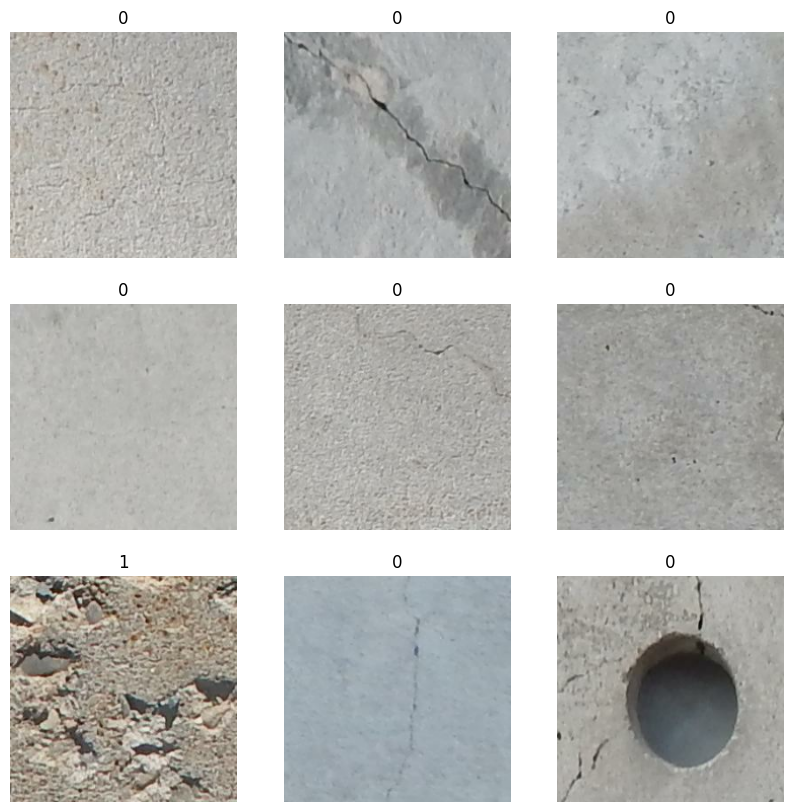

In [3]:
##Taking a look to the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#### Due to issues loading one of the model, I decided to copy and past the code for the model to this notebook here.

In [4]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-08-07 17:59:51.037920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


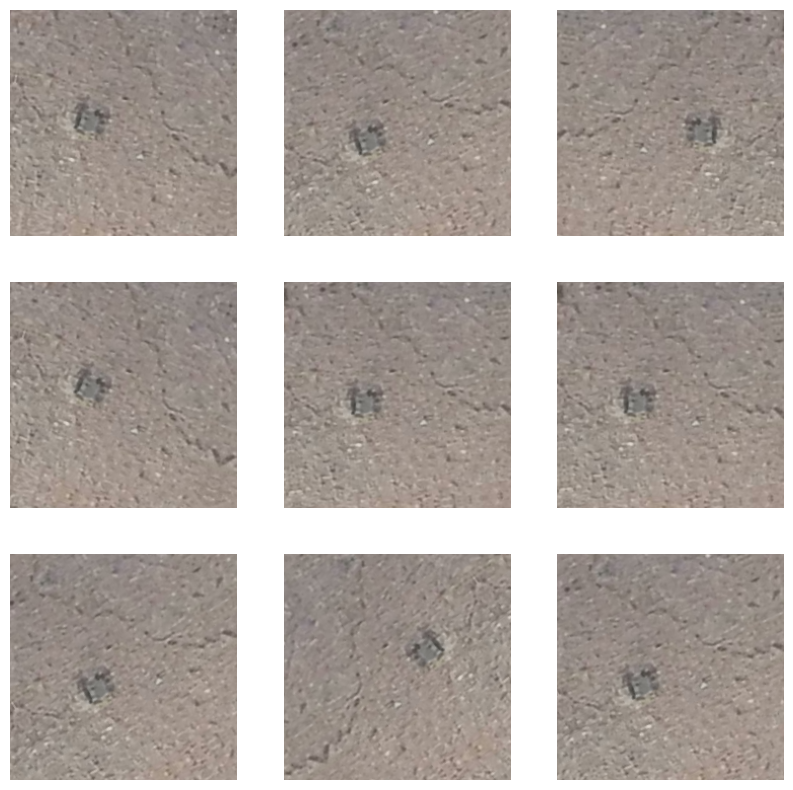

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [6]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [7]:
def make_model_1(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model_1(input_shape=image_size + (3,), num_classes=2)
##keras.utils.plot_model(model, show_shapes=True)

In [8]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - acc: 0.4948 - loss: 0.8743 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - acc: 0.6037 - loss: 0.7645 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5762 - loss: 0.7053 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - acc: 0.6263 - loss: 0.7206 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - acc: 0.5391 - loss: 0.7211 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5609 - loss: 0.7406 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - acc: 0.6400 - loss: 0.6499 - val_acc: 0.5000 - val_loss: 0.6936
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - acc: 0.6137 - loss: 0.7095 - val_acc: 0.5000 - val_loss: 0.6935


#### **Transfer Learning ResNet50**

In [9]:
def make_transfer_model_Res(input_shape, num_classes):
    # Load the pre-trained weights of ResNet50 and freeze the weights
    backbone = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.resnet50.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)


In [10]:
model= make_transfer_model_Res(input_shape=image_size + (3,), num_classes=2)

In [16]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - acc: 0.5219 - loss: 0.7817 - val_acc: 0.5000 - val_loss: 0.6949
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5368 - loss: 0.6588 - val_acc: 0.5000 - val_loss: 0.6966
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - acc: 0.5633 - loss: 0.6708 - val_acc: 0.5000 - val_loss: 0.6991
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - acc: 0.6599 - loss: 0.6966 - val_acc: 0.5000 - val_loss: 0.6977
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.6037 - loss: 0.6281 - val_acc: 0.5000 - val_loss: 0.7012
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - acc: 0.6210 - loss: 0.6447 - val_acc: 0.5000 - val_loss: 0.7059
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.6363 - loss: 0.6784 - val_acc: 0.5000 - val_loss: 0.7023
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - acc: 0.5240 - loss: 0.6871 - val_acc: 0.5000 - val_loss: 0.7081


In [19]:
# Save the model
model.save('make_transfer_model_Res.keras') # Use .keras or .h5 extension

# Load the model
loaded_model_res = keras.models.load_model('make_transfer_model_Res.keras')

In [20]:
##load the model
loaded_model_Dense = keras.models.load_model('make_transfer_model.keras')

In [21]:
# Load the model
loaded_model_2= keras.models.load_model('make_model_2.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 962ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step


2024-08-07 18:28:51.953752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


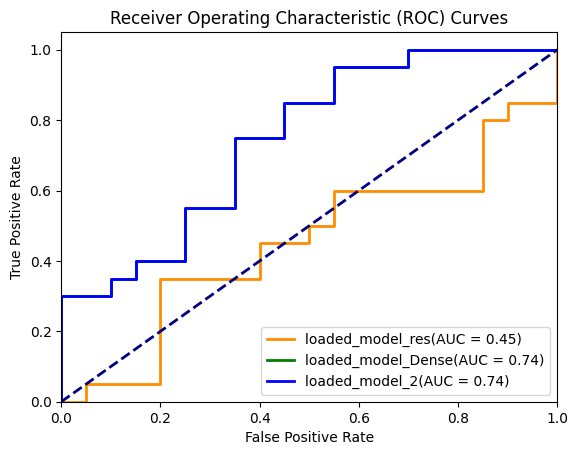

In [25]:
# Get predictions for the validation dataset
y_pred_1 =loaded_model_res.predict(val_ds)
y_pred_2 = loaded_model_Dense .predict(val_ds)
y_pred_3 = loaded_model_2.predict(val_ds)

# Assuming 'val_ds' has labels accessible as 'val_ds.labels'
y_true = []
for _, label in val_ds:
  y_true.extend(label.numpy())

y_true = np.array(y_true)

# Calculate ROC curves and AUC scores
fpr_1, tpr_1, _ = roc_curve(y_true, y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_true, y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_true, y_pred_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# Plot ROC curves
plt.figure()
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='loaded_model_res(AUC = %0.2f)' % roc_auc_1)
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='loaded_model_Dense(AUC = %0.2f)' % roc_auc_2)
plt.plot(fpr_3, tpr_3, color='blue', lw=2, label='loaded_model_2(AUC = %0.2f)' % roc_auc_3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

#### As we can see the the different basemodel and the DenseNet169 performed  better than the  ResNet50 model